In [24]:
# import pyspark libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, array
from pyspark.sql.types import IntegerType, StringType, BooleanType, DateType, FloatType
import pyspark.sql.functions as sql_func
from pyspark.sql.functions import isnan, count, when, col, desc, udf, sort_array, asc, avg, rank, mean, first, ceil, rand
from pyspark.sql.window import Window
from pyspark import SparkContext, SparkConf

#import Python libraries
import math
import re
import datetime
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
sc.install_pypi_package("Cython")
sc.install_pypi_package("pybind11")
sc.install_pypi_package("pythran")
sc.uninstall_package("numpy")
sc.uninstall_package("pip")
sc.install_pypi_package("pip==21.3.1")
sc.install_pypi_package("numpy==1.21.4")
sc.install_pypi_package("pandas==0.25.1")
sc.install_pypi_package("matplotlib==3.0.1")
sc.install_pypi_package("seaborn==0.9.0")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/3d/48/bbca549da0b0f636c0f161e84d30172c40aafe99552680f297da7fedf102/Cython-0.29.24-cp37-cp37m-manylinux1_x86_64.whl

  Using cached https://files.pythonhosted.org/packages/a8/3b/fc246e1d4c7547a7a07df830128e93c6215e9b93dcb118b2a47a70726153/pybind11-2.8.1-py2.py3-none-any.whl

  Using cached https://files.pythonhosted.org/packages/0a/c4/187ae2c4d39fabb8e0bb75521a00b04ba51bf37622ab799d5fc28182ea5d/pythran-0.10.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/5f/1c/b59500a88c5c3d9d601c5ca62b9df5e0964764472faed82a182958a922c5/gast-0.5.3-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/a3/58/35da89ee790598a0700ea49b2a66594140f44dec458c07e8e3d4979137fc/ply-3.11-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/cc/4a/af3f1b3d00efd47309b7a0e28351e06453727fa55d9b3a45fd4b91031a63/beniget-0.4.1-py3-none-any.whl

Not uninstalling numpy at /usr/local/lib64/python3.7/site-pa

In [1]:
sc.list_packages()

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
11,application_1637063911317_0012,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

aws-cfn-bootstrap (2.0)
beautifulsoup4 (4.9.3)
boto (2.49.0)
click (8.0.1)
docutils (0.14)
jmespath (0.10.0)
joblib (1.0.1)
lockfile (0.11.0)
lxml (4.6.3)
mysqlclient (1.4.2)
nltk (3.6.2)
nose (1.3.4)
numpy (1.16.5)
pip (9.0.1)
py-dateutil (2.2)
pystache (0.5.4)
python-daemon (2.2.3)
python37-sagemaker-pyspark (1.4.1)
pytz (2021.1)
PyYAML (5.4.1)
regex (2021.8.3)
setuptools (28.8.0)
simplejson (3.2.0)
six (1.13.0)
tqdm (4.62.1)
wheel (0.29.0)
windmill (1.6)

DEPRECATION: The default format will switch to columns in the future. You can use --format=(legacy|columns) (or define a format=(legacy|columns) in your pip.conf under the [list] section) to disable this warning.
You are using pip version 9.0.1, however version 21.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

In [5]:
# create a Spark session with configuration
spark = SparkSession.builder.appName("Sparkify").getOrCreate()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
#Load the dataset and print schema
df = spark.read.json("s3n://udacity-dsnd/sparkify/sparkify_event_data.json")
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

In [7]:
#We drop dulicated rows 
df = df.dropDuplicates()

#We drop rows with NAN userId and sessionId
df = df.filter(df["userId"] != np.nan)
df = df.filter(df["sessionId"] != np.nan)
df.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

26259199

In [8]:
#Number of unique users (by ID)
Num_Unique_Users = df.select('userId').distinct().count()
print("There are {} distinct users (by userID)".format(Num_Unique_Users))

#Number of different type of pages
Num_Unique_Pages = df.select('page').distinct().count()
print("There are {} distinct page types (by userID)".format(Num_Unique_Pages))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

There are 22278 distinct users (by userID)
There are 22 distinct page types (by userID)

In [9]:
#Define churn as user ever been to Cancellation Confirmation page
cancel_churn = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df = df.withColumn("Cancel", cancel_churn("page"))

#Define downgrade as user ever been to Submit Downgrade page
downgrade_churn = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
df = df.withColumn("Downgrade", downgrade_churn("page"))

#Define upgrade as user ever been to Submit Upgrade page
upgrade_churn = udf(lambda x: 1 if x == "Submit Upgrade" else 0, IntegerType())
df = df.withColumn("Upgrade", upgrade_churn("page"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
#Define window for time span calculation
windowSpec  = Window.partitionBy("userId")

#Create new column containing time span in days
df = df.withColumn("Time-Span", ceil((sql_func.max(col('ts')).over(windowSpec) - sql_func.min(col('ts')).over(windowSpec))/86400000))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
#Plot count of user activities recorded in our dataset
user_count = df.groupBy('userId').count().orderBy("count").toPandas()
plt.figure(figsize = [20,10])
plt.hist(user_count['count'], bins = 1000)
plt.xlabel("Count of User Activities")
plt.ylabel("Frequency")
plt.title("Distribution of Count of User Activities")
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Text(0.5, 1.0, 'Distribution of Count of User Activities')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

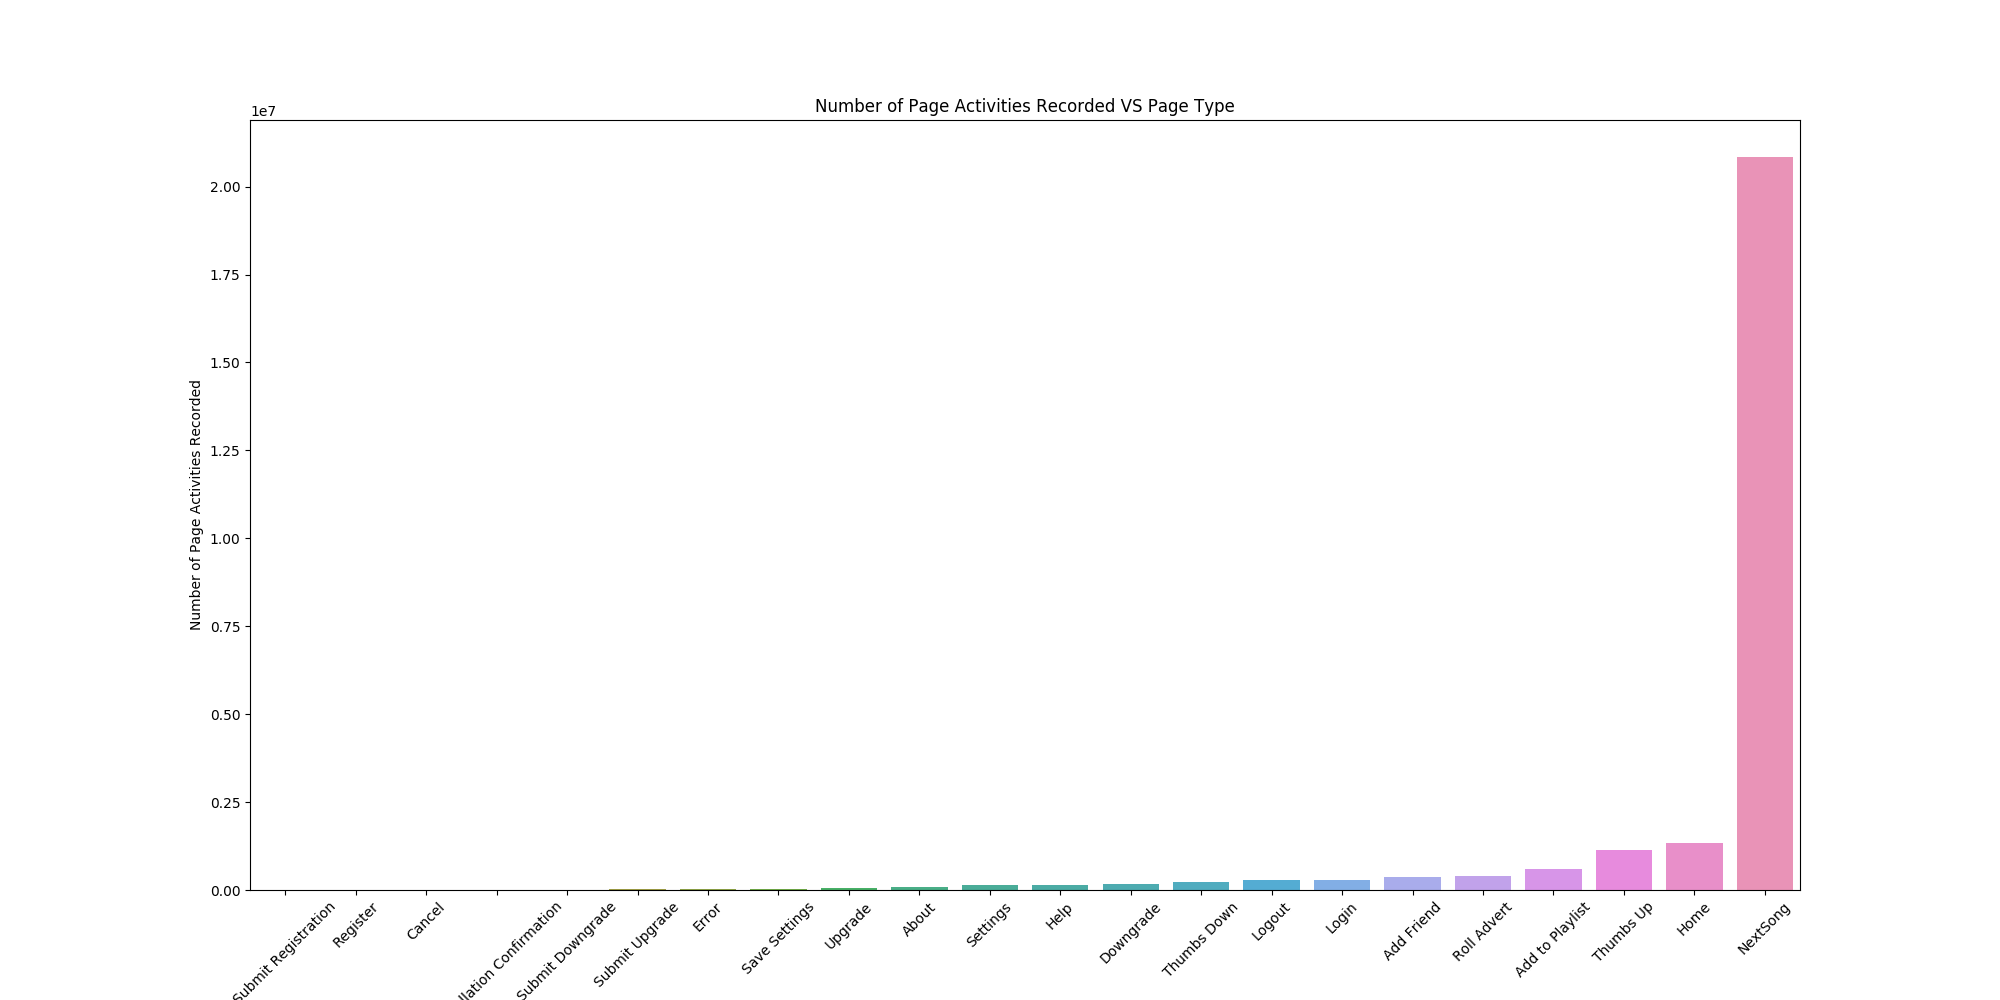

In [23]:
#Plot number of page activities recorded by page type
page_count = df.groupBy('page').count().sort("count", ascending = True).toPandas()
plt.figure(figsize = [20,10])
sb.barplot(x = 'page', y = 'count', data = page_count)
plt.xticks(rotation = 45)
plt.xlabel("Page Type")
plt.ylabel("Number of Page Activities Recorded")
plt.title("Number of Page Activities Recorded VS Page Type")
%matplot plt

In [22]:
user_count['count']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0             1
1             1
2             1
3             1
4             1
          ...  
22273     11858
22274     12372
22275     12831
22276     13591
22277    778479
Name: count, Length: 22278, dtype: int64